In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install holidays
import holidays
from scipy.stats import skew
from scipy.stats import kurtosis

In [2]:
# Define file pathname
#base = "/Users/ziadharmanani/Documents/GitHub/INF1340-Ridership/Ridership-Data/Bike share ridership "
base = "Bike share ridership/Bike share ridership "
extension = [
    "2023-01", "2023-02", "2023-03", "2023-04", "2023-05", "2023-06",
    "2023-07", "2023-08", "2023-09", "2023-10", "2023-11", "2023-12",
    ]

# Define columns order in a list
columns = [
    "Trip Id", "Trip Duration", "Start Station Id", "Start Time",
    "Start Station Name", "End Station Id", "End Time",
    "End Station Name", "Bike Id", "User Type"
    ]

# Used to store file paths
paths = []

# Loop through file extensions and combine them to locate them individually
for month in extension:
    path = base + month + ".csv"
    paths.append(path)

# Used to store the individual data frames
all_dfs = []

# Clean columns (Inconsistencies between 2024 and other years)
# Mismatch beteen the years issued a lot of NaN values. Trip Id was duplicated (2024 had its own).
for file in paths:
    df_temp = pd.read_csv(file, encoding = "latin1")
    df_temp.columns = [col.replace("ï»¿", "").strip() for col in df_temp.columns]

    # Used to clean BOM character for "Trip Id" (2024)
    if "ï»¿Trip Id" in df_temp.columns:
        df_temp["Trip Id"] = df_temp["ï»¿Trip Id"]
        df_temp = df_temp.drop(columns = ["ï»¿Trip Id"])

    #remove extra space in Trip Duration column
    #df.columns = df.columns.str.replace("Trip  Duration", "Trip Duration")
    df_temp.rename(columns={"Trip  Duration": "Trip Duration"}, inplace=True)

    # Reindexes the data frame according to columns list.
    df_temp = df_temp.reindex(columns = columns)
    all_dfs.append(df_temp)

# Concatinate dataframe
df = pd.concat(all_dfs, ignore_index = True)

# Drop "Model" to stay consistent with previous years (Only present in 2024)
df = df.drop(columns = ["Model", "Bike Id"], errors = "ignore")


df = df.set_index("Trip Id")

# NEXT STEPS: Look into Start Station Name and End Station Name.


In [3]:
df.columns.tolist()

['Trip Duration',
 'Start Station Id',
 'Start Time',
 'Start Station Name',
 'End Station Id',
 'End Time',
 'End Station Name',
 'User Type']

In [4]:
print(f"Start Station Name: {df['Start Station Name'].nunique()}")
print(f"End Station Name: {df['End Station Name'].nunique()}")

Start Station Name: 593
End Station Name: 592


In [5]:
df.isna().sum()

Trip Duration              0
Start Station Id           0
Start Time                 0
Start Station Name    595075
End Station Id          2944
End Time                   0
End Station Name      598563
User Type                  0
dtype: int64

In [6]:
### START TIME
#split start time into 2 columns
df[['Start Date', 'Start Time']] = df['Start Time'].str.split(' ', expand=True)

#move start date to the 3rd index
col = df.pop('Start Date')
df.insert(3, col.name, col)

#convert date to datetime format
df['Start Date'] = pd.to_datetime(df['Start Date'], format = '%m/%d/%Y')

In [7]:
### END TIME
#split start time into 2 columns
df[['End Date', 'End Time']] = df['End Time'].str.split(' ', expand=True)

#move start date to the 3rd index
col = df.pop('End Date')
df.insert(3, col.name, col)

#convert date to datetime format
df['End Date'] = pd.to_datetime(df['End Date'], format = '%m/%d/%Y')

In [8]:
### START TIME
#split date into day/month but keep og column
df['Start Day'] = df['Start Date'].dt.day

df['Start Month'] = df['Start Date'].dt.month

#move start day to the 4th index
col = df.pop('Start Day')
df.insert(4, col.name, col)

#move start month to the 5th index
col = df.pop('Start Month')
df.insert(5, col.name, col)


#change trip duration to minutes/hours
def convert(seconds):
    seconds = seconds % (24 * 60 * 60)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60

    return "%d:%02d:%02d" % (hour, minutes, seconds)


#df['Trip Duration'] = df['Trip Duration'].apply(convert)
df.tail()

,Trip Duration,Start Station Id,Start Time,End Date,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type
Trip Id,,,,,,,,,,,,
26682732,185,7391,23:56,2023-12-31,31,12,2023-12-31,Yonge St / Dundas Sq,7041.0,23:59,Edward St / Yonge St,Casual Member
26682733,802,7366,23:56,2024-01-01,31,12,2023-12-31,Fort York Blvd / Bathurst St SMART,7048.0,00:10,Front St W / Yonge St (Hockey Hall of Fame),Casual Member
26682735,1314,7203,23:57,2024-01-01,31,12,2023-12-31,Bathurst St/Queens Quay(Billy Bishop Airport),7719.0,00:19,NaN,Casual Member
26682737,371,7788,23:58,2024-01-01,31,12,2023-12-31,NaN,7788.0,00:05,NaN,Casual Member
26682738,1271,7298,23:59,2024-01-01,31,12,2023-12-31,Bathurst St / Adelaide St W,7075.0,00:21,Queens Quay W / Dan Leckie Way,Casual Member


In [9]:
### END TIME
#split date into day/month but keep og column
df['End Day'] = df['End Date'].dt.day

df['End Month'] = df['End Date'].dt.month

#move start day to the 4th index
col = df.pop('End Day')
df.insert(4, col.name, col)

#move start month to the 5th index
col = df.pop('End Month')
df.insert(5, col.name, col)


#change trip duration to minutes/hours
def convert(seconds):
    seconds = seconds % (24 * 60 * 60)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60

    return "%d:%02d:%02d" % (hour, minutes, seconds)


#df['Trip Duration'] = df['Trip Duration'].apply(convert)
df.tail()

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type
Trip Id,,,,,,,,,,,,,,
26682732,185,7391,23:56,2023-12-31,31,12,31,12,2023-12-31,Yonge St / Dundas Sq,7041.0,23:59,Edward St / Yonge St,Casual Member
26682733,802,7366,23:56,2024-01-01,1,1,31,12,2023-12-31,Fort York Blvd / Bathurst St SMART,7048.0,00:10,Front St W / Yonge St (Hockey Hall of Fame),Casual Member
26682735,1314,7203,23:57,2024-01-01,1,1,31,12,2023-12-31,Bathurst St/Queens Quay(Billy Bishop Airport),7719.0,00:19,NaN,Casual Member
26682737,371,7788,23:58,2024-01-01,1,1,31,12,2023-12-31,NaN,7788.0,00:05,NaN,Casual Member
26682738,1271,7298,23:59,2024-01-01,1,1,31,12,2023-12-31,Bathurst St / Adelaide St W,7075.0,00:21,Queens Quay W / Dan Leckie Way,Casual Member


In [10]:
#create weekday/weekend column
df['Weekday/Weekend'] = df['Start Date'].dt.weekday.apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

df.head()

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type,Weekday/Weekend
Trip Id,,,,,,,,,,,,,,,
20148784,840,7022,00:00,2023-01-01,1,1,1,1,2023-01-01,Simcoe St / Queen St W,7703.0,00:14,NaN,Casual Member,Weekend
20148785,722,7399,00:01,2023-01-01,1,1,1,1,2023-01-01,Lower Jarvis / Queens Quay E,7533.0,00:13,Housey St / Dan Leckie Way,Casual Member,Weekend
20148786,1054,7269,00:02,2023-01-01,1,1,1,1,2023-01-01,Toronto Eaton Centre (Yonge St),7076.0,00:20,York St / Queens Quay W,Annual Member,Weekend
20148790,1329,7721,00:04,2023-01-01,1,1,1,1,2023-01-01,NaN,7685.0,00:26,NaN,Casual Member,Weekend
20148791,1291,7721,00:04,2023-01-01,1,1,1,1,2023-01-01,NaN,7685.0,00:26,NaN,Casual Member,Weekend


In [11]:
# Checking if the Weekday/Weekend column is correct in July
df[(df['Weekday/Weekend'] == 'Weekend') & (df['Start Date'].dt.year == 2023) & (df['Start Date'].dt.month == 7)].sample(10)

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type,Weekday/Weekend
Trip Id,,,,,,,,,,,,,,,
23486999,773,7263,15:26,2023-07-30,30,7,30,7,2023-07-30,Walton St / Elizabeth St - SMART,7058.0,15:39,Huron/ Harbord St,Casual Member,Weekend
22889653,833,7164,17:17,2023-07-08,8,7,8,7,2023-07-08,Gould St / Yonge St (Ryerson University),7168.0,17:31,Queens Quay / Yonge St,Casual Member,Weekend
22891273,1943,7274,18:19,2023-07-08,8,7,8,7,2023-07-08,Queen's Park Cres E / Grosvenor St - SMART,7435.0,18:52,Rushton Rd / St Clair Ave W,Casual Member,Weekend
23473040,1147,7344,01:33,2023-07-30,30,7,30,7,2023-07-30,Cherry Beach,7702.0,01:53,NaN,Casual Member,Weekend
22902523,349,7264,10:13,2023-07-09,9,7,9,7,2023-07-09,Bloor St E / Huntley St - SMART,7089.0,10:19,Church St / Wood St,Casual Member,Weekend
22910962,1059,7430,15:06,2023-07-09,9,7,9,7,2023-07-09,Marilyn Bell Park Tennis Court,7259.0,15:24,Lower Spadina Ave / Lake Shore Blvd,Annual Member,Weekend
23463974,632,7719,18:40,2023-07-29,29,7,29,7,2023-07-29,NaN,7047.0,18:50,University Ave / Gerrard St W (East Side),Casual Member,Weekend
23268793,780,7475,14:29,2023-07-22,22,7,22,7,2023-07-22,Jarvis St / Richmond St E,7256.0,14:42,Vanauley St / Queen St W - SMART,Casual Member,Weekend
23301133,852,7000,16:40,2023-07-23,23,7,23,7,2023-07-23,Fort York Blvd / Capreol Ct,7077.0,16:54,College Park South,Casual Member,Weekend


In [12]:
# Added a new column Trip Duration (mm:ss)
df['Trip Duration (mm:ss)'] = df['Trip Duration'].apply(lambda x: f"{x // 60}:{x % 60:02d}")

df.sample(10)

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type,Weekday/Weekend,Trip Duration (mm:ss)
Trip Id,,,,,,,,,,,,,,,,
20671574,960,7029,13:31,2023-03-17,17,3,17,3,2023-03-17,Bay St / Bloor St W (East Side),7037.0,13:47,Bathurst St / Dundas St W,Casual Member,Weekday,16:00
20425695,680,7398,12:54,2023-02-11,11,2,11,2,2023-02-11,York St / Lakeshore St W - South,7391.0,13:05,Yonge St / Dundas Sq,Annual Member,Weekend,11:20
24598386,651,7368,21:05,2023-09-07,7,9,7,9,2023-09-07,Lisgar St / Dundas St SMART,7049.0,21:16,Queen St W / Portland St,Casual Member,Weekday,10:51
21156239,244,7102,08:26,2023-04-24,24,4,24,4,2023-04-24,Nelson St / Duncan St,7599.0,08:30,Richmond St W / York St,Casual Member,Weekday,4:04
25356008,851,7176,11:45,2023-10-04,4,10,4,10,2023-10-04,Bathurst St / Fort York Blvd,7248.0,11:59,Baldwin Ave / Spadina Ave - SMART,Casual Member,Weekday,14:11
20622189,249,7002,02:04,2023-03-10,10,3,10,3,2023-03-10,St. George St / Bloor St W,7007.0,02:09,College St / Huron St,Casual Member,Weekday,4:09
24420983,717,7662,16:37,2023-09-01,1,9,1,9,2023-09-01,Beaty Ave / Queen St W,7712.0,16:49,NaN,Casual Member,Weekday,11:57
20349690,825,7296,10:38,2023-01-31,31,1,31,1,2023-01-31,Westmoreland Ave / Fernbank Ave,7298.0,10:52,Bathurst St / Adelaide St W,Annual Member,Weekday,13:45
23610207,579,7236,17:21,2023-08-03,3,8,3,8,2023-08-03,Thompson St / Broadview Ave - SMART,7551.0,17:30,The Esplanade / Hahn Pl,Casual Member,Weekday,9:39


In [13]:
# Lists that determine what we defined as peak hours
peak_morning = [6, 7, 8, 9]
peak_evening = [15, 16, 17, 18, 19]

# Assign hour the 'Start Time' hour
hours = pd.to_datetime(df['Start Time'], format='%H:%M').dt.hour

# Defined list for a cleaner code 
conditions = [hours.isin(peak_morning), hours.isin(peak_evening)]
choices = ["Morning", "Evening"]

df['Peak Hour'] = np.select(conditions, choices, default = "Off Peak")

df.sample(10)

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type,Weekday/Weekend,Trip Duration (mm:ss),Peak Hour
Trip Id,,,,,,,,,,,,,,,,,
21965742,422,7483,09:46,2023-06-02,2,6,2,6,2023-06-02,Southwood Dr / Kingston Rd - SMART,7486.0,09:53,Gerrard St E / Ted Reeve Dr,Casual Member,Weekday,7:02,Morning
24617546,933,7246,16:40,2023-09-08,8,9,8,9,2023-09-08,Yonge St / Bloor St,7102.0,16:56,Nelson St / Duncan St,Casual Member,Weekday,15:33,Evening
23112255,751,7072,23:22,2023-07-16,16,7,16,7,2023-07-16,Fleet St / Bathurst St,7168.0,23:34,Queens Quay / Yonge St,Casual Member,Weekend,12:31,Off Peak
21087257,1287,7239,14:39,2023-04-19,19,4,19,4,2023-04-19,Bloor St W / Manning Ave - SMART,7257.0,15:01,Dundas St W / St. Patrick St,Casual Member,Weekday,21:27,Off Peak
26340911,539,7473,15:54,2023-11-26,26,11,26,11,2023-11-26,Adelaide St W / Strachan Ave,7102.0,16:03,Nelson St / Duncan St,Casual Member,Weekend,8:59,Evening
21170744,334,7054,09:11,2023-04-25,25,4,25,4,2023-04-25,Navy Wharf Ct. / Bremner Blvd.,7033.0,09:16,Union Station,Annual Member,Weekday,5:34,Morning
26116634,637,7203,08:53,2023-11-11,11,11,11,11,2023-11-11,Bathurst St/Queens Quay(Billy Bishop Airport),7168.0,09:04,Queens Quay / Yonge St,Casual Member,Weekend,10:37,Morning
25102451,339,7112,11:25,2023-09-25,25,9,25,9,2023-09-25,Liberty St / Fraser Ave Green P,7322.0,11:30,King St W / Brant St,Casual Member,Weekday,5:39,Off Peak
21014881,341,7256,09:03,2023-04-15,15,4,15,4,2023-04-15,Vanauley St / Queen St W - SMART,7078.0,09:08,College St / Major St,Casual Member,Weekend,5:41,Morning


In [14]:
df.columns.tolist()

['Trip Duration',
 'Start Station Id',
 'Start Time',
 'End Date',
 'End Day',
 'End Month',
 'Start Day',
 'Start Month',
 'Start Date',
 'Start Station Name',
 'End Station Id',
 'End Time',
 'End Station Name',
 'User Type',
 'Weekday/Weekend',
 'Trip Duration (mm:ss)',
 'Peak Hour']

In [15]:
order = ['Trip Duration', 'Trip Duration (mm:ss)', 
         'Start Station Id', 'Start Station Name', 'Start Time', 'Start Day', 'Start Month', 'Start Date', 
         'End Station Id', 'End Station Name', 'End Time', 'End Day', 'End Month', 'End Date',
         'User Type', 'Weekday/Weekend', 'Peak Hour']

df = df[order]
#df = df.drop(columns = ["Trip Duration"], errors = "ignore")
df.sample(10)

,Trip Duration,Trip Duration (mm:ss),Start Station Id,Start Station Name,Start Time,Start Day,Start Month,Start Date,End Station Id,End Station Name,End Time,End Day,End Month,End Date,User Type,Weekday/Weekend,Peak Hour
Trip Id,,,,,,,,,,,,,,,,,
24781497,415,6:55,7457,Queen's Park Cres W / Hoskin Ave,12:26,14,9,2023-09-14,7022.0,Simcoe St / Queen St W,12:33,14,9,2023-09-14,Casual Member,Weekday,Off Peak
22765900,300,5:00,7703,NaN,09:06,4,7,2023-07-04,7071.0,161 Bleecker St (South of Wellesley),09:11,4,7,2023-07-04,Casual Member,Weekday,Morning
22871930,722,12:02,7536,Palmerston Ave / Dundas St W,01:00,8,7,2023-07-08,7536.0,Palmerston Ave / Dundas St W,01:12,8,7,2023-07-08,Casual Member,Weekend,Off Peak
22932904,679,11:19,7245,Tecumseth St / Queen St W - SMART,11:52,10,7,2023-07-10,7015.0,King St W / Bay St (West Side),12:03,10,7,2023-07-10,Casual Member,Weekday,Off Peak
21496152,421,7:01,7174,Bloor St W / Dundas St W,17:13,13,5,2023-05-13,7477.0,Antler St / Campbell Ave - SMART,17:20,13,5,2023-05-13,Annual Member,Weekend,Evening
24888453,252,4:12,7058,Huron/ Harbord St,20:22,17,9,2023-09-17,7007.0,College St / Huron St,20:26,17,9,2023-09-17,Casual Member,Weekend,Off Peak
26675423,350,5:50,7022,Simcoe St / Queen St W,18:08,30,12,2023-12-30,7458.0,Church St / Lombard St,18:14,30,12,2023-12-30,Casual Member,Weekend,Evening
21018968,102,1:42,7065,Dundas St E / Parliament St,12:41,15,4,2023-04-15,7100.0,Dundas St E / Regent Park Blvd,12:42,15,4,2023-04-15,Casual Member,Weekend,Off Peak
24456479,586,9:46,7766,NaN,20:05,2,9,2023-09-02,7548.0,St Joseph St / Bay St - SMART,20:14,2,9,2023-09-02,Casual Member,Weekend,Off Peak


In [16]:
# reset numeric variable to categorical
df['Start Station Id']=df['Start Station Id'].astype('category')
df['End Station Id']=df['End Station Id'].astype('category')
df['Start Day']=df['Start Day'].astype('category')
df['End Day']=df['End Day'].astype('category')
df['Start Month']=df['Start Month'].astype('category')
df['End Month']=df['End Month'].astype('category')

In [17]:
# calculate summary statistics

def summary_stats(column):
    # remove na values
    series = column.dropna()

    return {
        "mean": series.mean()/ 60,
        "median": series.median() /60,
        "mode": (series.mode()/60).tolist(),  # Could be multiple modes
        "std_dev": series.std()/ 60
    }

#Trip_summary = summary_stats(df, 'Trip Duration (mm:ss)')

trip_summary = summary_stats(df['Trip Duration'])

print(trip_summary)


{'mean': 17.98991376780887, 'median': 11.45, 'mode': [7.2], 'std_dev': 146.63290742721023}


In [18]:
# function to find outliers using z-score
def find_outliers_zscore(column, threshold=3):
    # remove na values
    series = column.dropna()
    
    mean = series.mean()/60
    std = series.std()/60
    
    z_scores = (series/60 - mean) / std

        # boolean mask
    mask = np.abs(z_scores) > threshold

    # return list of outlier values
    return series[mask].tolist()



outliers = find_outliers_zscore(df["Trip Duration"])

# proportion of outliers
num_outliers = df['Trip Duration'].isin(outliers).sum()
proportion_outliers = num_outliers / len(df)

print(proportion_outliers)


0.0009920987421805274


In [19]:
# remove outliers

# replace outliers with NaN
df['Trip Duration'] = df['Trip Duration'].mask(df['Trip Duration'].isin(outliers), np.nan)

# drop rows where Trip Duration is NaN
df = df.dropna(subset=['Trip Duration']).reset_index(drop=True)

In [20]:
# calculate summary statistics

def summary_stats(column):
    # remove na values
    series = column.dropna()

    return {
        "mean": series.mean()/ 60,
        "median": series.median() /60,
        "mode": (series.mode()/60).tolist(),  # Could be multiple modes
        "std_dev": series.std()/ 60
    }

trip_summary = summary_stats(df['Trip Duration'])

print(trip_summary)


{'mean': 15.847835565757384, 'median': 11.45, 'mode': [7.2], 'std_dev': 18.41774166455249}


In [21]:
# group by 'peak/offpeak' and apply summary_stats
trip_summary_by_peak = df.groupby('Peak Hour')['Trip Duration'].apply(summary_stats)

print(trip_summary_by_peak)

Peak Hour         
Evening    mean                   16.632388
           median                     12.05
           mode                       [7.8]
           std_dev                18.421291
Morning    mean                   12.770837
           median                      10.3
           mode       [0.03333333333333333]
           std_dev                 13.49441
Off Peak   mean                   16.177246
           median                 11.366667
           mode                       [7.2]
           std_dev                19.738693
Name: Trip Duration, dtype: object


In [22]:
# group by 'peak/offpeak' and apply summary_stats
trip_summary_by_peak = df.groupby('Start Month')['Trip Duration'].apply(summary_stats)

print(trip_summary_by_peak)

Start Month         
1            mean                    12.79995
             median                       9.9
             mode       [0.03333333333333333]
             std_dev                13.129628
2            mean                   13.449612
             median                 10.416667
             mode         [7.466666666666667]
             std_dev                13.672272
3            mean                   13.233047
             median                      10.3
             mode         [5.816666666666666]
             std_dev                13.008713
4            mean                    15.65183
             median                      11.2
             mode         [7.033333333333333]
             std_dev                17.932853
5            mean                   17.645312
             median                 12.316667
             mode         [7.416666666666667]
             std_dev                21.099279
6            mean                   17.102112
             

In [23]:
# calculate proportion of missing values in dataset
def missing_proportion(df):
# return proportion of missing values
    return df.isna().mean()

missing_prop = missing_proportion(df)

print(missing_prop)

Trip Duration            0.000000
Trip Duration (mm:ss)    0.000000
Start Station Id         0.000000
Start Station Name       0.104146
Start Time               0.000000
Start Day                0.000000
Start Month              0.000000
Start Date               0.000000
End Station Id           0.000508
End Station Name         0.104727
End Time                 0.000000
End Day                  0.000000
End Month                0.000000
End Date                 0.000000
User Type                0.000000
Weekday/Weekend          0.000000
Peak Hour                0.000000
dtype: float64


In [24]:
# run skew and kurtosis
def skew_kurtosis_all(df):
    numeric_df = df.select_dtypes(include=['number'])

    return pd.DataFrame({
        "skew": numeric_df.skew(),
        "kurtosis": numeric_df.kurtosis()
    })

skew_kurtosis_df = skew_kurtosis_all(df)

print(skew_kurtosis_df)

                   skew   kurtosis
Trip Duration  7.417947  99.025541


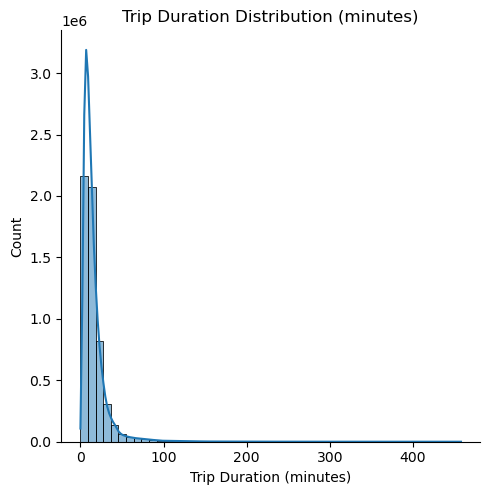

In [25]:
# visualize the distribution of the numeric variable - trip duration

#plot trip duration
sns.displot(data=df.assign(Trip_Duration_min=df['Trip Duration'] / 60),
            x='Trip_Duration_min', kind='hist', kde=True, bins=50)

plt.title('Trip Duration Distribution (minutes)')
plt.xlabel('Trip Duration (minutes)')

plt.show()

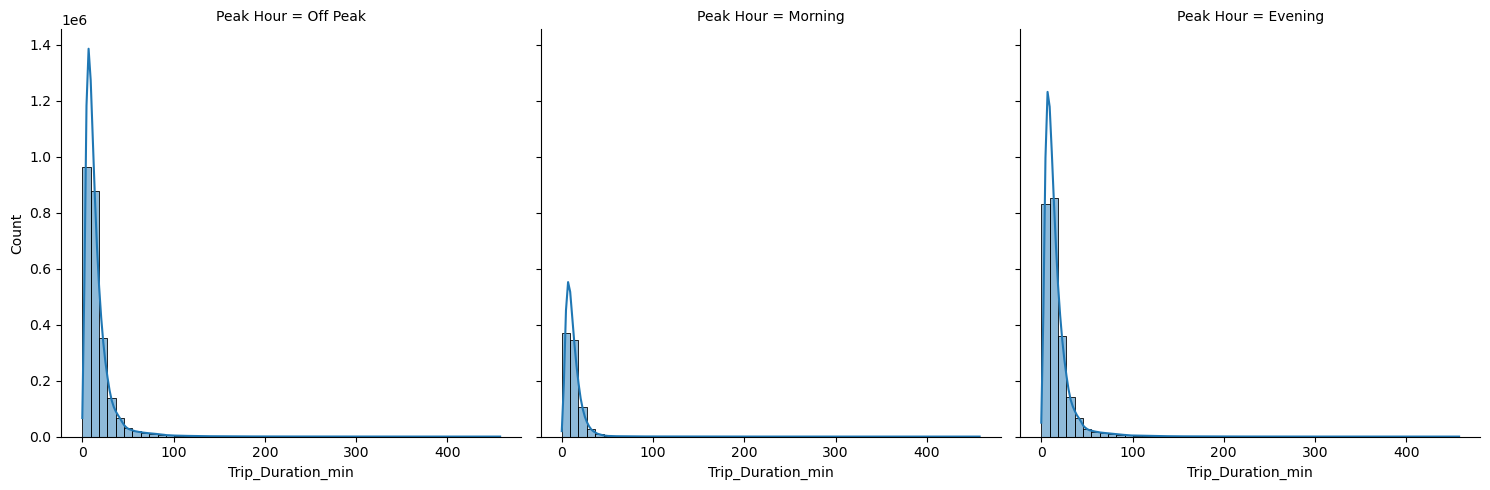

In [26]:
#plot the distribution of the numeric variable - trip duration grouped by Peak Hour
sns.displot(data=df.assign(Trip_Duration_min=df['Trip Duration'] / 60),
            x='Trip_Duration_min', col='Peak Hour' ,kind='hist', kde=True, bins=50)

plt.show()

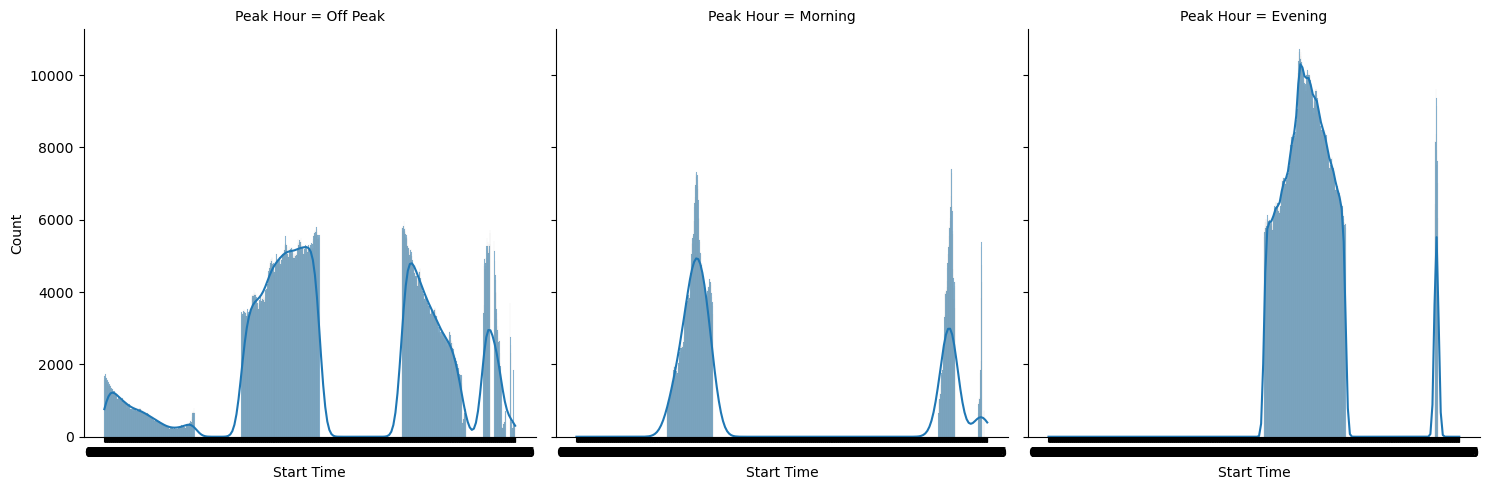

In [69]:
#plot start time distribution grouped by peak hour
sns.displot(data=df, x='Start Time', col='Peak Hour', kind='hist', kde='show', bins = 50)

plt.show()

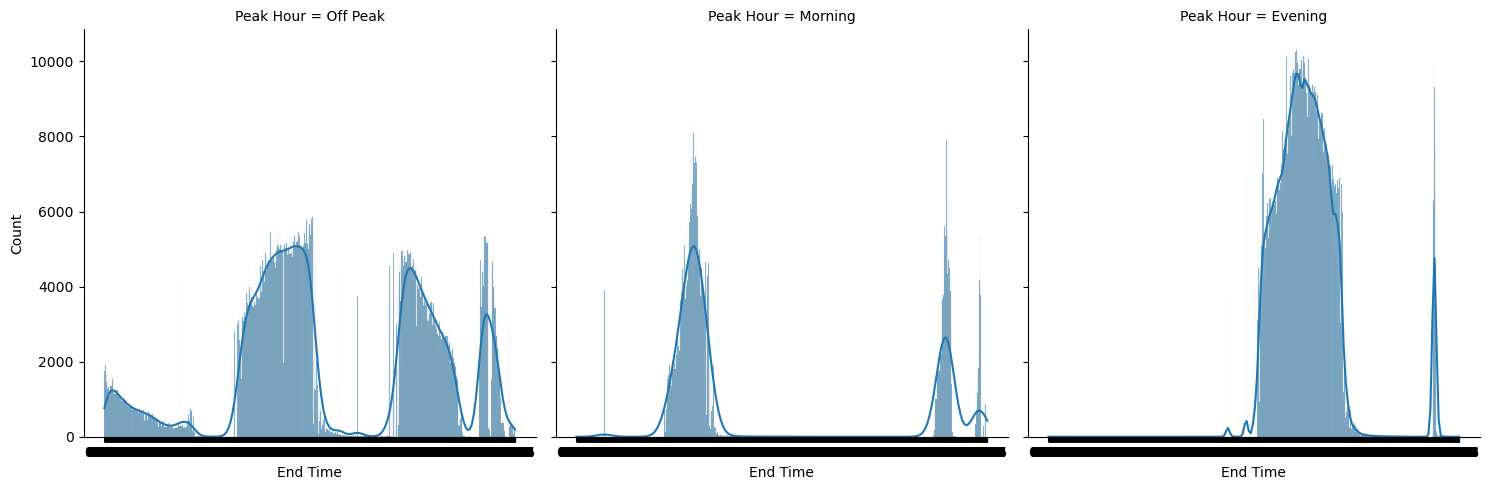

In [70]:
#plot end time distribution grouped by peak hour
sns.displot(data=df, x='End Time',col='Peak Hour', kind='hist', kde='show', bins = 50)

plt.show()

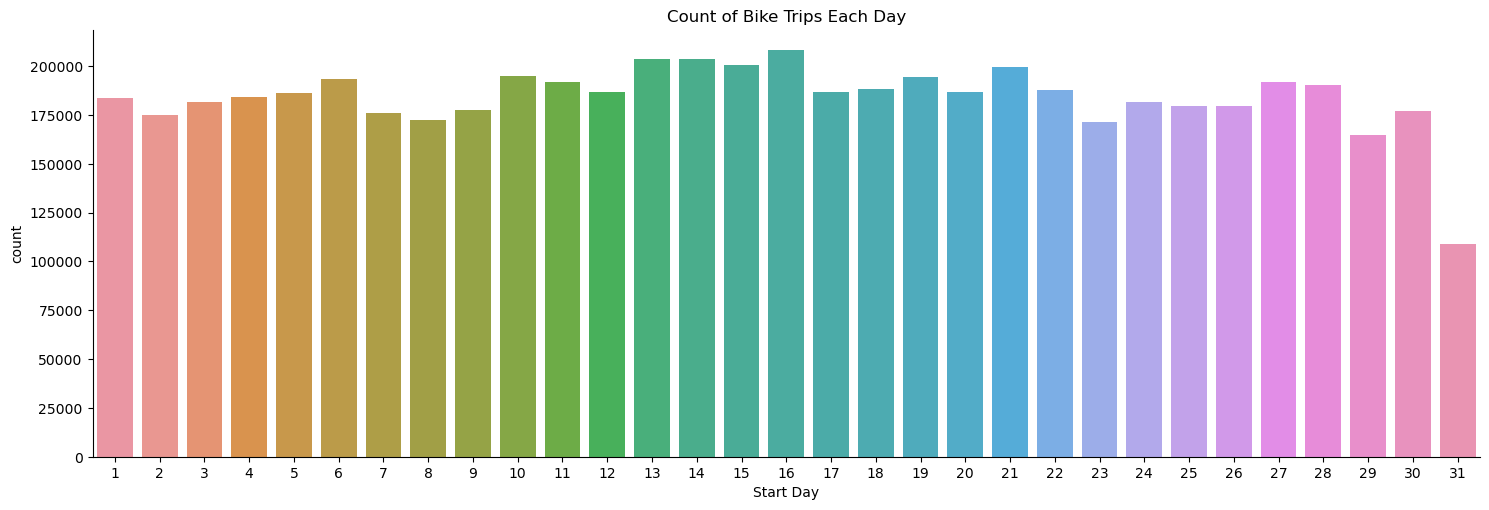

In [29]:
# plot categorical variable - Start Day
sns.catplot(data=df, x='Start Day', kind='count', aspect = 3)
plt.title('Count of Bike Trips Each Day')

plt.show()

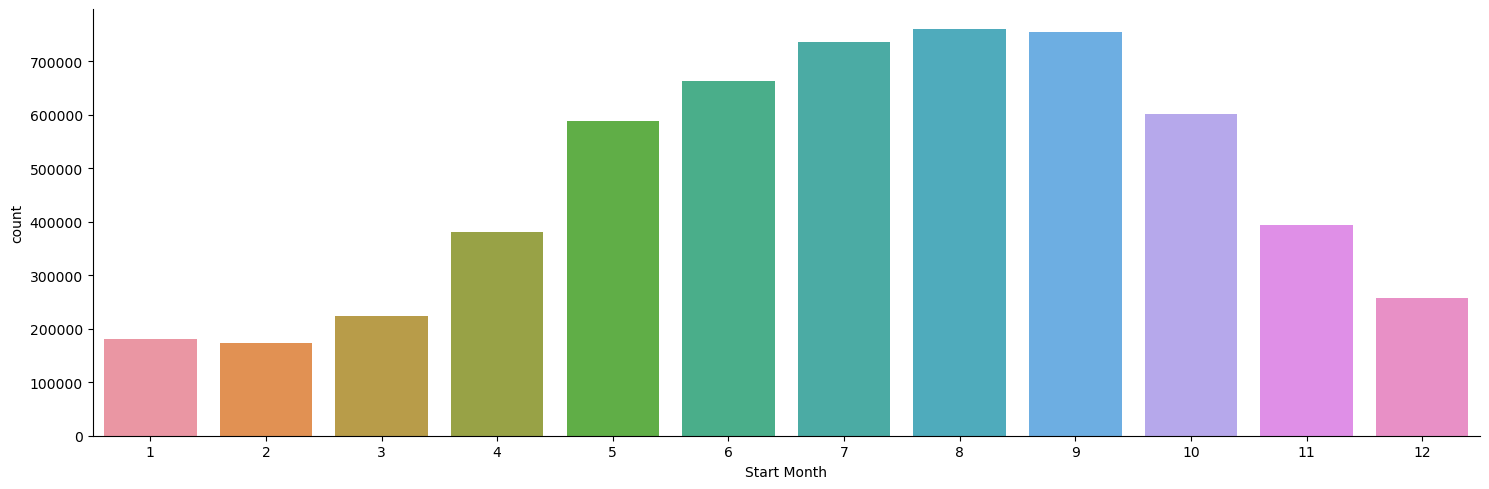

In [38]:
# plot categorical variable - Start Month
sns.catplot(data=df, x='Start Month', kind='count', aspect = 3)
plt.title('Count of Bike Trips in Each Month')

plt.show()

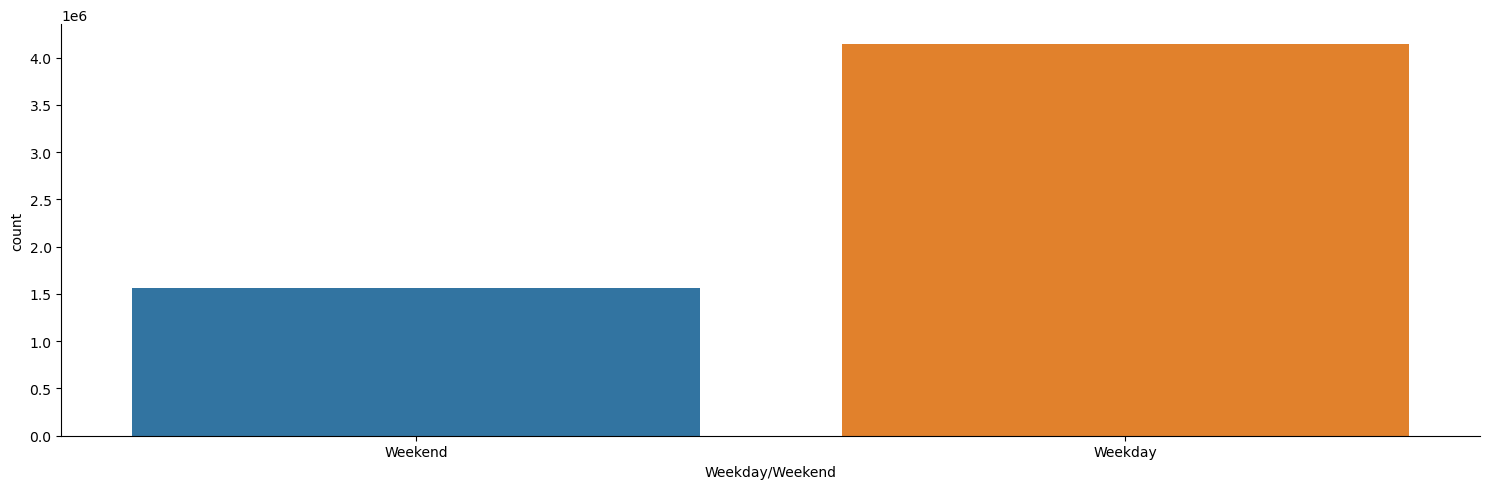

In [57]:
# plot categorical variable - Weekday/Weekend
sns.catplot(data=df, x='Weekday/Weekend', kind='count', aspect = 3)
plt.title('Count of Weekday Bike Trips')

plt.show()

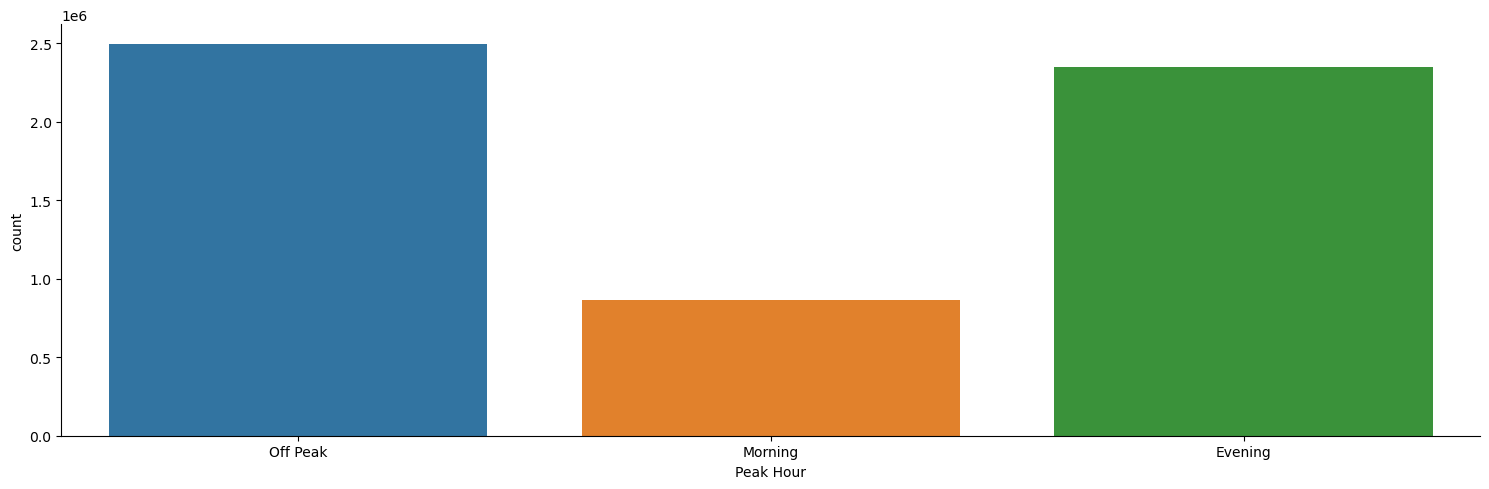

In [58]:
# plot categorical variable - Peak Hour
sns.catplot(data=df, x='Peak Hour', kind='count', aspect = 3)
plt.title('Count of Peak Hours Bike Trips')

plt.show()

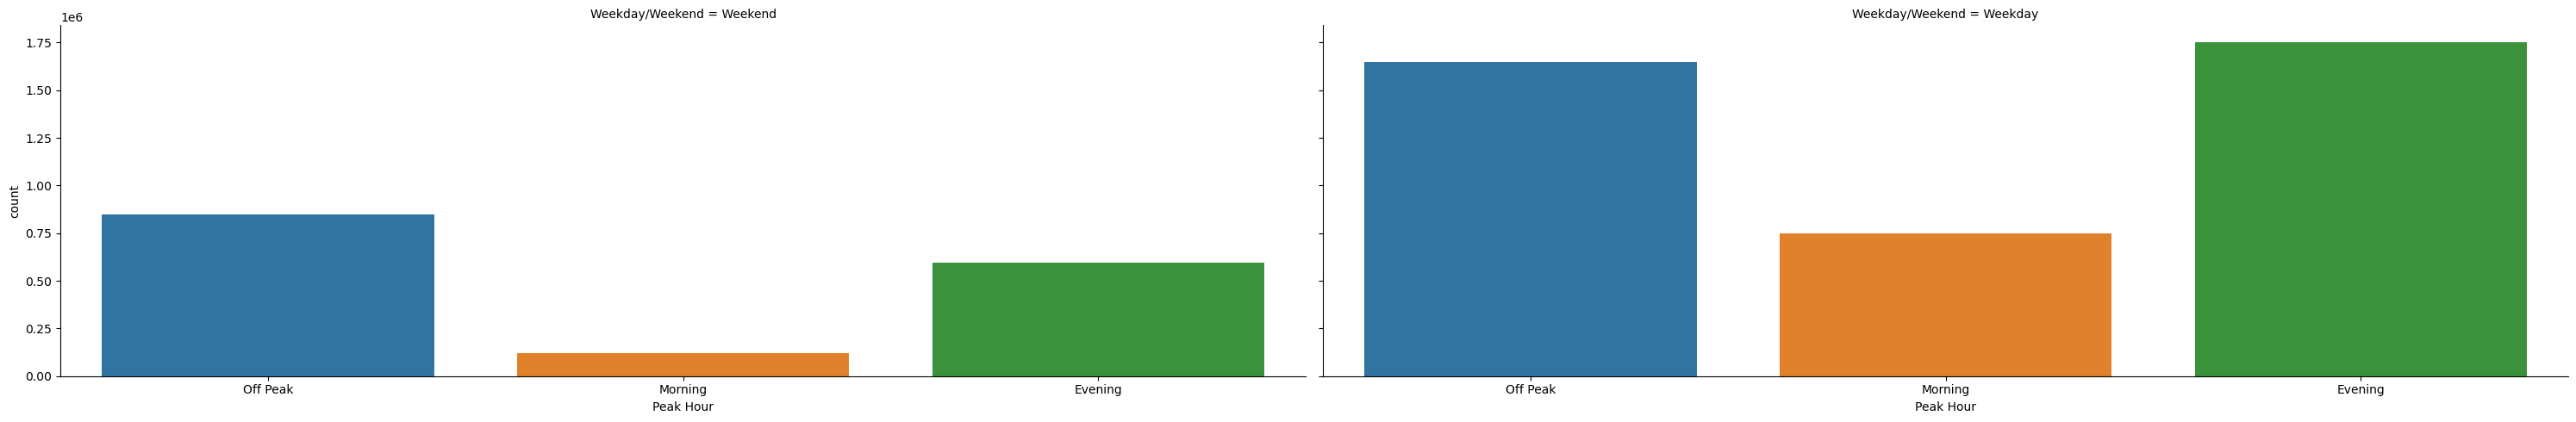

In [31]:
# plot categorical variable - Peak Hour
sns.catplot(data=df, x='Peak Hour', col='Weekday/Weekend',kind='count', aspect = 3)
#plt.title('Count of Peak Hours Bike Trips')

plt.show()

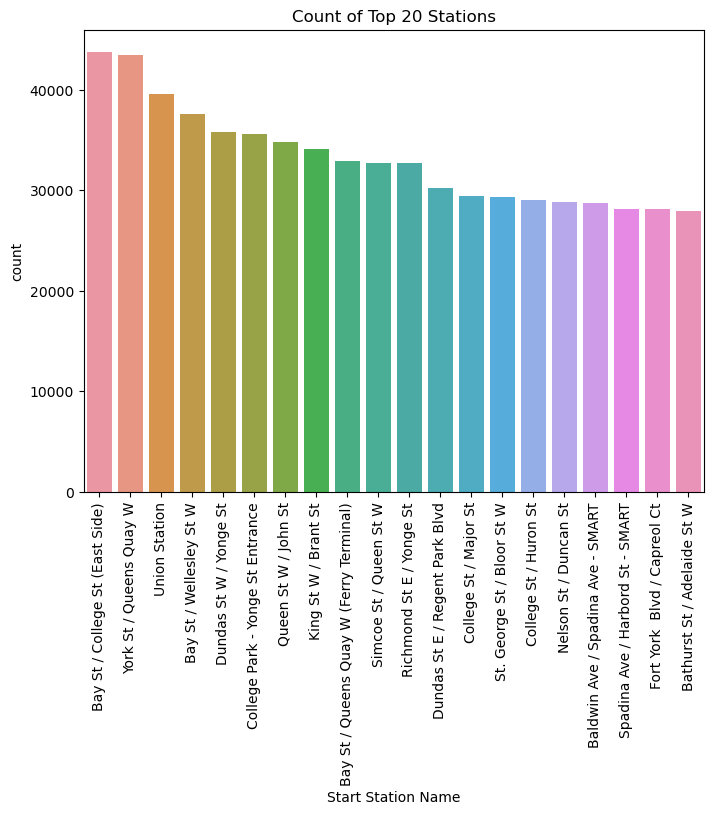

In [ ]:
top_20_Stations = df['Start Station Name'].value_counts().nlargest(20).index

# Filter the DataFrame to include only the top N categories
df_top_20 = df[df['Start Station Name'].isin(top_20_Stations)]

# Create the countplot, ordering by frequency
plt.figure(figsize=(8, 6))
sns.countplot(data=df_top_20, x='Start Station Name', order=top_20_Stations)
plt.title('Count of Top 20 Start Stations')
plt.xticks(rotation='vertical')
plt.show()


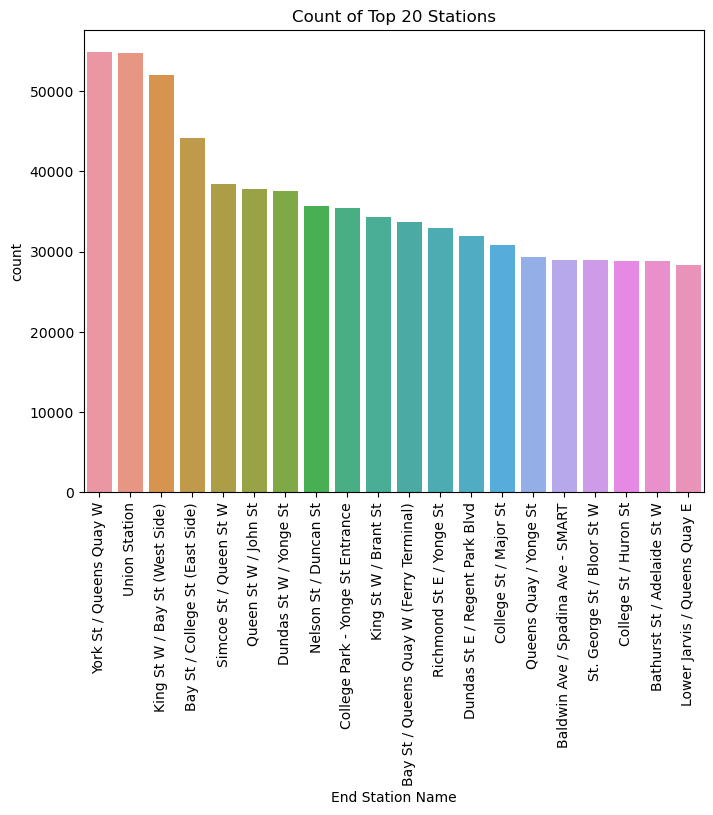

In [ ]:
top_20_Stations = df['End Station Name'].value_counts().nlargest(20).index

# Filter the DataFrame to include only the top N categories
df_top_20 = df[df['End Station Name'].isin(top_20_Stations)]

# Create the countplot, ordering by frequency
plt.figure(figsize=(8, 6))
sns.countplot(data=df_top_20, x='End Station Name', order=top_20_Stations)
plt.title('Count of Top 20 End Stations')
plt.xticks(rotation='vertical')
plt.show()